In [14]:
# Importing libraries
from sys import platform
# To import files from directories
import os; from os import listdir; from os.path import isfile, join
# rSNAPsim Image Processing
cwd = os.getcwd(); os.chdir('../../rsnaped');import rsnaped as rsp; os.chdir(cwd)
# Image reader
from skimage import io ; from skimage.io import imread
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
import matplotlib.path as mpltPath
# To manipulate arrays
import numpy as np 
import random
import re
from tqdm.notebook import tqdm
import scipy
import pandas as pd
import pathlib
import rsnaped as rsn

# importing cellpose
from cellpose import models, io
from skimage.measure import find_contours

# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image
# Figure style and size
mpl.rc('figure',  figsize=(7, 7)); mpl.rc('image', cmap='gray'); mpl.rc('axes', grid=False); mpl.rcParams['figure.dpi'] = 300
%matplotlib inline 

In [15]:
# Deffining the images path 
figName0 ='../../DataBases/sm_FISH_images/MS2-Cy3/ROI001_XY1621356985_Z00_T0_C0.tif'
figName1 ='../../DataBases/sm_FISH_images/MS2-Cy3/ROI001_XY1621356985_Z00_T0_C1.tif'
figName2 ='../../DataBases/sm_FISH_images/MS2-Cy3/ROI001_XY1621356985_Z00_T0_C2.tif'

#figName0 ='../../DataBases/sm_FISH_images/MS2-Cy5/ROI002_XY1621355013_Z00_T0_C0.tif'
#figName1 ='../../DataBases/sm_FISH_images/MS2-Cy5/ROI002_XY1621355013_Z00_T0_C1.tif'
#figName2 ='../../DataBases/sm_FISH_images/MS2-Cy5/ROI002_XY1621355013_Z00_T0_C2.tif'

files = [figName0,figName1,figName2]
list_images_separated_ch = [imread(f) for f in files]

In [16]:
list_images_separated_ch[0].shape

(21, 928, 624)

In [17]:
len(list_images_separated_ch[0].shape)

3

In [18]:
# Merging the images in a new one with dimensions [Z,Y,X,C]
merged_image = np.concatenate([list_images_separated_ch[i][..., np.newaxis] for i,_ in enumerate(list_images_separated_ch)],axis=-1)
merged_image.shape

(21, 928, 624, 3)

In [19]:
list_images= [merged_image]

In [20]:
merged_image_rm_extrema = rsn.RemoveExtrema(merged_image,max_percentile=90,ignore_channel=0).remove_outliers()

In [21]:
img = np.max(merged_image_rm_extrema, axis=0)

In [22]:
# Deffining the images path 
list_images_max = [img]
nimg = len(list_images_max)
list_images_max[0].shape

(928, 624, 3)

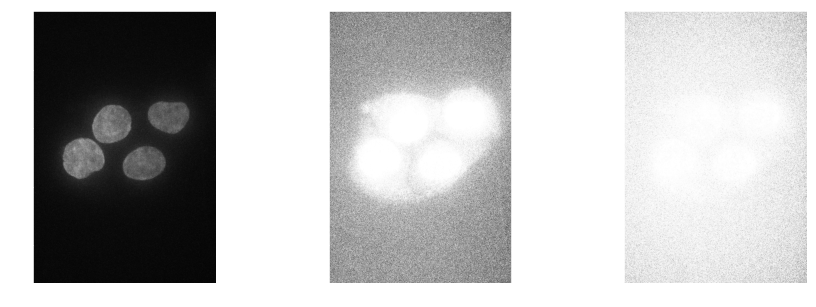

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].imshow(img[:,:,0])     
axes[1].imshow(img[:,:,1])    
axes[2].imshow(img[:,:,2])  
plt.show()

In [24]:
# Cell visualization 3D. To start visualization simply move the time slider.
#n_img =0
#controls, output = rsp.VisualizerVideo3D(list_images[n_img]).make_video_app()
#display(VBox([controls, output])); plt.rcParams['figure.figsize'] = [15, 15]

# <span style= "color:red"> Cell segmentation </span>

## Cell segmentaion using machine learning.
<span style="font-size:1em;"> CNN architecture based on U-Net. <span/>
<span style="font-size:1em;"> Cellpose by Dr. Carsen Stringer (Janelia). <span/>

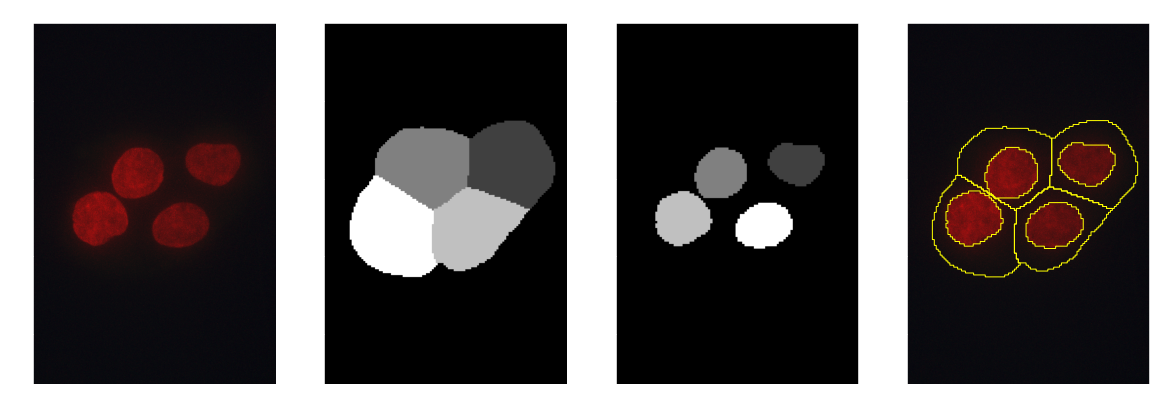

In [25]:
list_masks_complete_cells =[]
list_masks_nuclei =[]
list_masks_cytosol_no_nuclei =[]
list_index_paired_masks =[]
for i in range(0, nimg):
    masks_complete_cells,masks_nuclei,masks_cytosol_no_nuclei, index_paired_masks = rsp.CellposeFISH(list_images_max[i],channel_with_cytosol=[1,1], channel_with_nucleus=0, selected_z_slice=5, diameter_cytosol =150, diamter_nucleus=100, show_plot=1).calculate_masks()
    list_masks_complete_cells.append(masks_complete_cells)
    list_masks_nuclei.append(masks_nuclei)
    list_masks_cytosol_no_nuclei.append(masks_cytosol_no_nuclei)
    list_index_paired_masks.append(index_paired_masks)

## Example: visualizing all generated masks for a given image

RuntimeError: No active exception to reraise

In [ ]:
selected_image = 0
num_cells_in_image = list_index_paired_masks[selected_image].shape[0]
for i in range(0,num_cells_in_image):
    print('')
    print('Masks for image: File_Number_'+ str(selected_image) + ' Cell: ' + str(i) )
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, num_cells_in_image*5))
    axes[0].imshow(list_masks_complete_cells[selected_image][i])# mask cytosol
    axes[0].set(title='Cell_'+str(i)+'_mask_cytosol')
    axes[1].imshow(list_masks_nuclei[selected_image][i])# mask nucleus
    axes[1].set(title='Cell_'+str(i)+'_mask_nucleus')
    axes[2].imshow(list_masks_cytosol_no_nuclei[selected_image][i])# mask cytosol no nucleus
    axes[2].set(title='Cell_'+str(i)+'cyto_no_nuc')
    plt.show()

# <span style= "color:red"> Tracking </span>

Channel 0 is mRNA, Channel 1 is FLAG tag (labels both nascent and mature proteins), and Channel 2 is GFP (labels only mature protein).

In this excersice I will calculate number and their intensity of spots in the nucleus for channel 1 (FLAG)

In [ ]:
particle_size = 5
selected_channel = 1  #mRNA
minimal_occurence_in_z_axis =  3 # minimal number of frames to consider a trajectory

In [ ]:
# Function that accepts a list of images in 3d, calculates a 3D tracking and returns a list of list containing the trajectories for each cell in each image
def compute_tracking_3D (list_images,list_maks, minimal_occurence_in_z_axis =3, particle_size=5,selected_channel=0):
    nimg = len(list_images)
    list_complete_DF= []
    list_complete_num_spots_per_cell = []
    list_complete_videos_filtered = []
    # nested loops that calculate the 3D tracking
    for i in tqdm(range(0,nimg)): 
        list_Dataframe_trajectories= []
        list_num_spots_per_cell = []
        list_videos_filtered = []
        max_num_cells = list_index_paired_masks[i].shape[0]
        for cell in range (0,max_num_cells):
            Dataframe_trajectories, number_detected_trajectories, filtered_video = rsp.Trackpy(list_images[i],list_maks[i][cell],particle_size=particle_size, selected_channel=selected_channel,minimal_frames=minimal_occurence_in_z_axis,optimization_iterations = 30, show_plot =0,FISH_image=1).perform_tracking()   
            list_Dataframe_trajectories.append(Dataframe_trajectories)
            list_num_spots_per_cell.append(number_detected_trajectories)
            list_videos_filtered.append(filtered_video)
        #Appending list of lists
        list_complete_DF.append(list_Dataframe_trajectories)
        list_complete_num_spots_per_cell.append(list_num_spots_per_cell)
        list_complete_videos_filtered.append(list_videos_filtered)

    return list_complete_DF, list_complete_num_spots_per_cell, list_complete_videos_filtered # each list contains the data for each cell in each image. list = [image_0,image_1,image_N] and inside each image a sublist in the form: image_0 = [cell_0, cell_1, cell_N]

In [ ]:
list_complete_DF, list_complete_num_spots_per_cell, list_complete_videos_filtered = compute_tracking_3D (list_images,list_masks_complete_cells, minimal_occurence_in_z_axis =minimal_occurence_in_z_axis, particle_size=particle_size,selected_channel=selected_channel)

In [ ]:
#for idx in tqdm(range(0,nimg)):
#    max_num_cells = list_index_paired_masks[idx].shape[0]
#    for cell in range (0,max_num_cells):
#        file_name = 'Image_'+str(idx)+'_Cell'+str(cell)+'.tif' # Creating a file name
#        rsp.VisualizerImage(list_images[idx],list_videos_filtered=list_complete_videos_filtered[idx][cell],list_selected_particles_dataframe=list_complete_DF[idx][cell],list_files_names=file_name,list_mask_array = list_masks_complete_cells[idx][cell],selected_channel=selected_channel,selected_timepoint=0,normalize=False,individual_figure_size=5).plot()

# <span style= "color:red"> Intensity </span>

In [ ]:
# Function that accepts a list of images in 3d, calculates a 3D tracking and returns a list of list containing the trajectories for each cell in each image
def compute_intensity_3D (list_images,list_complete_DF, list_index_paired_masks,particle_size=5):
    nimg = len(list_images)
    list_complete_array_intensities= []
    list_complete_DF_intensity=[]
    # nested loops that calculate the 3D tracking
    for i in tqdm(range(0,nimg)): 
        list_array_intensities= []
        list_DF =[]
        max_num_cells = len(list_index_paired_masks[i])
        for cell in range (0,max_num_cells):
            DataFrame_particles_intensities, array_intensities, _, _,_, _, _ = rsp.Intensity(list_images[i][cell],particle_size,list_complete_DF[i][cell],method='total_intensity',show_plot=0).calculate_intensity()           
            list_array_intensities.append(array_intensities)
            list_DF.append(DataFrame_particles_intensities)
        #Appending list of lists
        list_complete_array_intensities.append(list_array_intensities)
        list_complete_DF_intensity.append(list_DF)
    return list_complete_array_intensities,list_complete_DF_intensity # each list contains the data for each cell in each image. list = [image_0,image_1,image_N] and inside each image a sublist in the form: image_0 = [cell_0, cell_1, cell_N]

In [ ]:
list_complete_array_intensities,list_complete_DF_intensity = compute_intensity_3D (list_complete_videos_filtered,list_complete_DF, list_index_paired_masks,particle_size=5)

## Example showing an intensity data frame

In [ ]:
list_complete_DF_intensity[0][0]

## Plotting intensities per cell in cytosol and nucleus

In [ ]:
list_complete_int =[]
for i in range(0,nimg):
    list_int =[]
    max_num_cells = len(list_index_paired_masks[i])
    for cell in range (0,max_num_cells):
        df = list_complete_DF_intensity[i][cell]
        n_particles = df['particle'].nunique()
        intensity_values_in_image = np.zeros((n_particles))
        for j in range (0,n_particles):
            intensity_values_in_image[j] = np.amax(df[df['particle'] ==j].green_int_mean.values)         
        list_int.append(intensity_values_in_image)
    list_complete_int.append(list_int)

In [ ]:
# plotting

ncols =0
for i in range(0,nimg):
    max_num_cells = len(list_index_paired_masks[i])
    ncols+=max_num_cells
ncols   

fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(30, 2))
counter =0
for i in range(0,nimg):
    max_num_cells = len(list_index_paired_masks[i])
    for cell in range (0,max_num_cells):
        axes[counter].hist(list_complete_int[i][cell], alpha=0.95,bins=20,density=True, stacked=True, color=(random.random(),random.random(),random.random()) )
        counter+=1
        #axes[i].set(title=list_files_names[i][0:-4]);
plt.tight_layout()

In [ ]:
# Plotting distribution for all cells
plt.figure(figsize=(4,4))
selected_image =0
all_cell_int = [item for sublist in list_complete_int[selected_image] for item in sublist]
np_all_cell_int = np.asarray(all_cell_int)
plt.hist(np_all_cell_int[np_all_cell_int>0], alpha=0.95,bins=30,density=True, stacked=True, color=(random.random(),random.random(),random.random()) )
plt.title('all cells int')
plt.tight_layout()